## Routing Pattern
In this workbook we'll build a workflow that illustrates _Routing_. In this pattern you pick one of many options depending on a "decision" in the previous node. For example, consider the case of a call triaging agent for a cell center, say for a credit card company. Depending on the nature of the request - e.g. Balance Inquiry, Reporting Loss, Incorrect Charges etc. - the call is routed through different paths for servicing the customer request. 

<div align="center">
<img src="images/03-Routing.png" width="360" heigh="250" alt="Parallelization"/>
</div>

Here's what we'll be building in this example:
* We'll ask the LLM to create either a poem or story or joke on a topic (_LLM Call Router_ node)
* This node will extract our intent from the request and route to either the _LLM Call 1_ node (for joke) or _LLM Call 2_ node for poem or __LLM Call 3_ node for story creation.
* To help us extract user's intent (i.e. request for a _story_ or _poem_ or _joke_), we'll bind an LLM with a structured output that will tell us exactly what the user wants us to create.

In [1]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from typing import TypedDict
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph import StateGraph, START, END

In [2]:
load_dotenv(override=True)

console = Console()

In [3]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.4)

c:\Users\BHOBEMRMANISHJAGDISH\Dev\code\git_projects\learning_langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# based model to get structured output from LLM
from typing import Literal

class Route(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(
        None, description="The next step in the routing process"
    )


# bind the LLM with structured data as shown above so we can
# extract intent of user. Invoking the router_llm with a "Route" instance
# will set it's "step" member to one of ["joke", "story", "poem"]
# @see: the route_call function below
router_llm = llm.with_structured_output(Route)

In [5]:
# the graph state
class State(TypedDict):
    input: str  # input from user
    decision: str  # decision made by the router
    output: str  # output from the agent
    log: bool  # flag to log message, if True

Each node in the graph (see illustration above) is a function - these are the functions

In [6]:
def generate_joke(state: State):
    """the LLM Call 1 brance - to generate the joke for given input by user"""
    response = llm.invoke(state["input"])
    if "log" in state.keys():
        console.print(f"[green]generate_joke() -> [/green] {response.content}")
    return {"output": response.content}


def generate_story(state: State):
    """the LLM Call 2 brance - to generate a story for given input by user"""
    response = llm.invoke(state["input"])
    if "log" in state.keys():
        console.print(f"[green]generate_story() -> [/green] {response.content}")
    return {"output": response.content}


def generate_poem(state: State):
    """the LLM Call 3 brance - to generate a poem for given input by user"""
    response = llm.invoke(state["input"])
    if "log" in state.keys():
        console.print(f"[green]generate_poem() -> [/green] {response.content}")
    return {"output": response.content}


def route_call(state: State):
    """the LLM call router node - routes the call to appropriate branch"""
    # NOTE: we call the router_llm in this call, not llm
    response = router_llm.invoke(
        [
            SystemMessage(
                content="Route the input to joke, story or poem based on user's request"
            ),
            HumanMessage(content=state["input"]),
        ]
    )
    # NOTE: router_llm returns structured output (== instance of Route class)
    # now "decision" will be set to one of ["joke", "story", "poem"]
    console.print(f"[bright red]We'll be creating a '{response.step}'[/bright red]")
    return {"decision": response.step}


def route_decision(state: State):
    """pick the graph node to route to next"""
    # returns "goto_joke" or "goto_story" or "goto_poem" depending
    # on value of state["decision"] == ["joke" or "story" or "poem"] respectively
    if state["decision"] == "joke":
        return "goto_joke"
    elif state["decision"] == "story":
        return "goto_story"
    elif state["decision"] == "poem":
        return "goto_poem"

In [7]:
# build out our graph
builder = StateGraph(State)

# add our nodes
builder.add_node("route_call", route_call)
builder.add_node("generate_joke", generate_joke)
builder.add_node("generate_story", generate_story)
builder.add_node("generate_poem", generate_poem)

# and edges
builder.add_edge(START, "route_call")
builder.add_conditional_edges(
    # from this node
    "route_call",
    # to this decider node
    route_decision,
    # and then respective node based on output of decider node
    {
        "goto_joke": "generate_joke",
        "goto_poem": "generate_poem",
        "goto_story": "generate_story",
    },
)
builder.add_edge("generate_joke", END)
builder.add_edge("generate_story", END)
builder.add_edge("generate_poem", END)
graph = builder.compile()

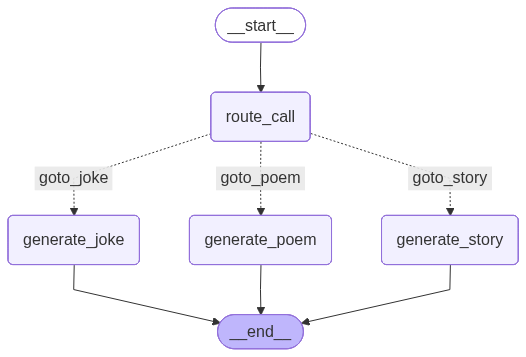

In [8]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# invoke the graph

# invoke graph with inputs such as
# "Write a story | joke | poem about {topic}"
# uncomment just one of the 3 lines below
# response = graph.invoke({"input": "Write a joke about cats"})
response = graph.invoke({"input": "Write a story about cats"})
#response = graph.invoke({"input": "Write a poem about cats"})
console.print(f"[green] Final output -> [/green] {response["output"]}")

We'll be creating a 'joke'

 Final output ->  Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!